
The Fashion MNIST dataset consists of 60,000 training images and 10,000 test images, each sized 28x28 pixels. This dataset contains 10 different clothing categories, such as T-shirts, trousers, sweaters, dresses, and shoes.

In this assignment, I will experiment with different Autoencoder architectures, train an Autoencoder, calculate and visualize the loss and accuracy for each epoch, and then select the best architecture to generate new clothes using the test data.

Import Library

In [1]:
%matplotlib inline
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import numpy as np
from PIL import Image
import copy
import time

Import data

In [2]:
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./fmnist/', train=True, download=True,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                          ])),
    batch_size=1024,
    shuffle=True,
    num_workers=1,
    pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./fmnist/', train=False,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                          ])),
    batch_size=1024,
    shuffle=True,
    num_workers=1,
    pin_memory=True
)

100%|██████████| 26.4M/26.4M [00:01<00:00, 19.6MB/s]


Extracting ./fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./fmnist/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 299kB/s]


Extracting ./fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./fmnist/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.43MB/s]


Extracting ./fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./fmnist/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 16.8MB/s]

Extracting ./fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./fmnist/FashionMNIST/raw



Define the transform to normalize the data

In [3]:

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])


trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


print(f"Number of samples in train set: {len(trainset)}")
print(f"Number of samples in test set: {len(testset)}")

100%|██████████| 26.4M/26.4M [00:01<00:00, 17.6MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 305kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.42MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.51MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Number of samples in train set: 60000
Number of samples in test set: 10000


Visualize a sample image from the training set

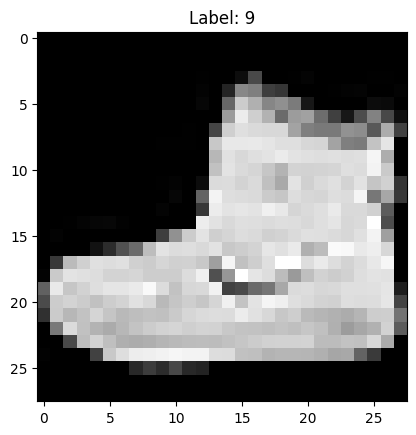

In [4]:

img, label = trainset[0]
img_np = img.squeeze(0).cpu().numpy()
plt.imshow(img_np, cmap='gray')
plt.title(f"Label: {label}")
plt.show()

In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 100),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(100, 28*28),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [6]:
class AutoencoderMedium(nn.Module):
    def __init__(self):
        super(AutoencoderMedium, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [7]:
class AutoencoderDeep(nn.Module):
    def __init__(self):
        super(AutoencoderDeep, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 28*28),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Training function

In [8]:

def train_autoencoder(model, trainloader, epochs=5):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_loss = []

    for epoch in range(epochs):
        running_loss = 0.0
        for data, _ in trainloader:
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, data.view(-1, 28*28))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(trainloader)
        train_loss.append(avg_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

    return train_loss

Create the Autoencoder models and , train each model

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model_simple = Autoencoder().to(device)
model_medium = AutoencoderMedium().to(device)
model_deep = AutoencoderDeep().to(device)


loss_simple = train_autoencoder(model_simple, trainloader, epochs=10)
loss_medium = train_autoencoder(model_medium, trainloader, epochs=10)
loss_deep = train_autoencoder(model_deep, trainloader, epochs=10)

Epoch [1/10], Loss: 0.6162
Epoch [2/10], Loss: 0.5927
Epoch [3/10], Loss: 0.5882
Epoch [4/10], Loss: 0.5859
Epoch [5/10], Loss: 0.5848
Epoch [6/10], Loss: 0.5842
Epoch [7/10], Loss: 0.5839
Epoch [8/10], Loss: 0.5837
Epoch [9/10], Loss: 0.5835
Epoch [10/10], Loss: 0.5834
Epoch [1/10], Loss: 0.6235
Epoch [2/10], Loss: 0.5988
Epoch [3/10], Loss: 0.5948
Epoch [4/10], Loss: 0.5926
Epoch [5/10], Loss: 0.5912
Epoch [6/10], Loss: 0.5903
Epoch [7/10], Loss: 0.5895
Epoch [8/10], Loss: 0.5888
Epoch [9/10], Loss: 0.5883
Epoch [10/10], Loss: 0.5879
Epoch [1/10], Loss: 0.6283
Epoch [2/10], Loss: 0.6016
Epoch [3/10], Loss: 0.5977
Epoch [4/10], Loss: 0.5952
Epoch [5/10], Loss: 0.5935
Epoch [6/10], Loss: 0.5925
Epoch [7/10], Loss: 0.5916
Epoch [8/10], Loss: 0.5909
Epoch [9/10], Loss: 0.5902
Epoch [10/10], Loss: 0.5897


Plot the training loss for each architecture

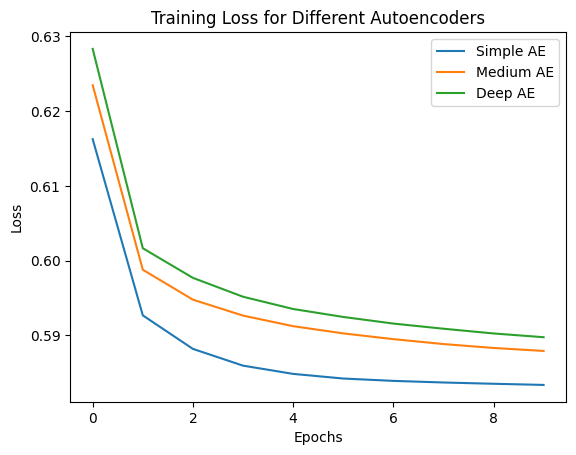

In [10]:

plt.plot(loss_simple, label='Simple AE')
plt.plot(loss_medium, label='Medium AE')
plt.plot(loss_deep, label='Deep AE')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss for Different Autoencoders')
plt.show()

 Plot 10 pairs of clothes (input, AE output)

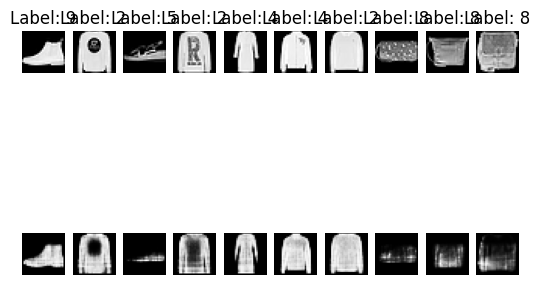

In [11]:
def generate_new_clothes(model, testloader, num_images=10):
    model.eval()
    with torch.no_grad():
        data, labels = next(iter(testloader))
        data = data.to(device)

        output = model(data)


        for i in range(num_images):
            plt.subplot(2, 10, i+1)
            plt.imshow(data[i].cpu().squeeze(0), cmap='gray')
            plt.title(f'Label: {labels[i]}')
            plt.axis('off')

            plt.subplot(2, 10, i+11)
            plt.imshow(output[i].cpu().view(28, 28), cmap='gray')
            plt.axis('off')
        plt.show()

generate_new_clothes(model_medium, testloader)

Regarding the chosen Autoencoder architecture, the simple model typically offers speed and ease of implementation, but it may not capture enough features in datasets like Fashion MNIST. The medium architecture, on the other hand, strikes a balance between simplicity and performance, allowing the model to extract features more effectively. Since this architecture performed better on the test set, without showing signs of overfitting, it was selected. Although deeper architectures are expected to provide better reconstruction results, considering the risks of overfitting and the higher computational requirements, the medium architecture turned out to be a more suitable choice.

As for the test set outputs, a properly trained Autoencoder should produce outputs that closely resemble the inputs. If there is a significant difference between the input and output, it indicates a shortcoming in the training. In that case, the model may need further training or architectural adjustments. Thus, I observed that the model was well-trained and produced outputs consistent with the test data.